# Boreholes

This notebook shows how to plot borehole data along with a groundwater measurement well.

Two different packages are used:
- `brodata`, to obtain and visualise borehole data from the BRO database
- `geost` to get Bodemkundig booronderzoek from the BRO database

In [ ]:
import contextily as ctx
import geopandas as gpd
import hydropandas as hpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point, LineString

In [2]:
# reading data from a groundwatermonitoring well (see notebook 01)
gw_bro = hpd.GroundwaterObs.from_bro("GMW000000041261", 1)

#### Borehole (Brodata)

Brodata can be installed using:

`pip install brodata`

In [10]:
import brodata

In [3]:
# select extent with a buffer around gw_bro
p = Point(gw_bro.x, gw_bro.y)
extent = np.array(p.buffer(750).bounds).astype(int)[[0, 2, 1, 3]]

# get bro ids of borehole data
gdf = brodata.bhr.get_characteristics(extent=extent)

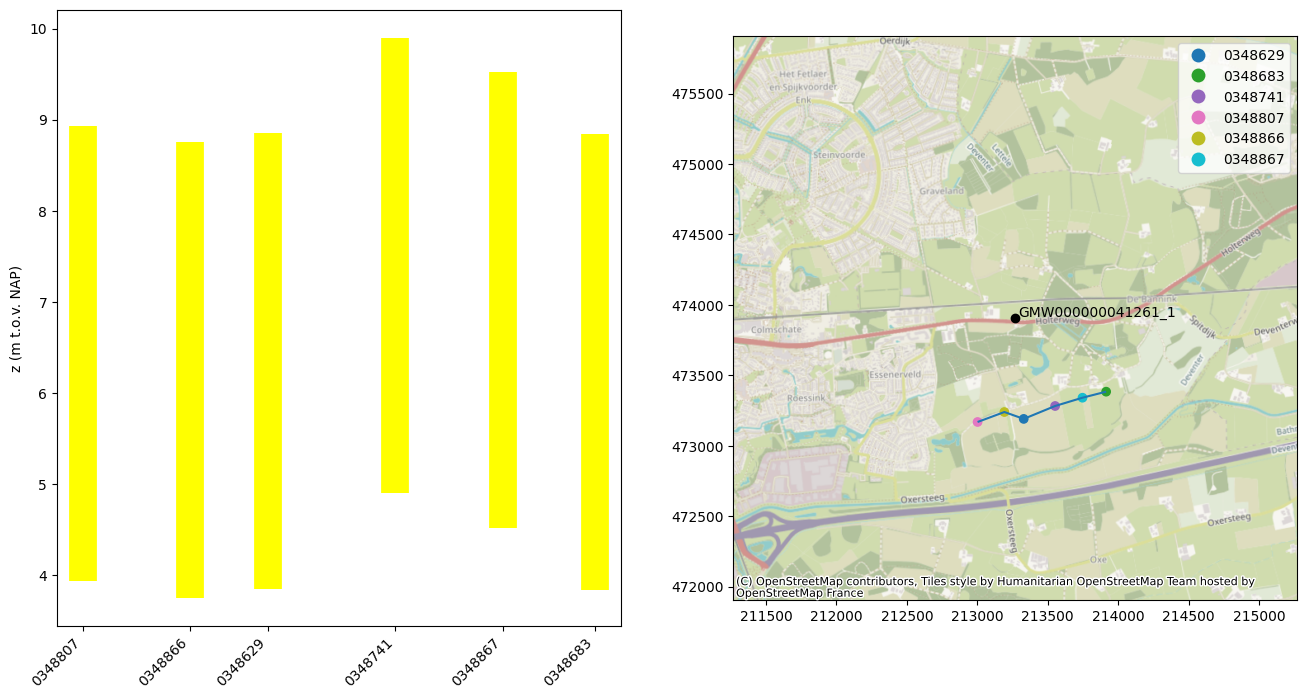

In [9]:
# plot borehole data
f, axes = plt.subplots(ncols=2, figsize=(16, 8))

gdf["broid"] = gdf.index.str[-7:]
gdf["x"] = gdf.geometry.x
gdf = gdf.sort_values("x")
gdf["geometry"] = gdf.geometry
l = LineString(gdf["deliveredLocation"].values)
s = pd.Series([l.project(point) for point in gdf["geometry"]], gdf.index)

# plot values
xticks = []
xticklabels = []
for bro_id in gdf.index:
    bhrgt = brodata.bhr.GeotechnicalBoreholeResearch.from_bro_id(bro_id)
    for x, bl in enumerate(bhrgt.descriptiveBoreholeLog):
        brodata.plot.bro_lithology(
            bl["layer"],
            x=s[bro_id],
            z=bhrgt.offset,
            drilling=bro_id,
            ax=axes[0],
            linewidth=20,
        )
        xticks.append(s[bro_id])
        xticklabels.append(bro_id[-7:])

axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticklabels, rotation=45, ha="right")
axes[0].set_ylabel("z (m t.o.v. NAP)")
# plot map

# plot well
axes[1].scatter(gw_bro.x, gw_bro.y, color="black")
axes[1].annotate(gw_bro.name, (gw_bro.x + 25, gw_bro.y + 10))

# plot boreholes
legend_labels = gdf["broid"].tolist()
gdf.plot("broid", ax=axes[1], legend=True)

# plot line
gpd.GeoDataFrame(geometry=[l]).plot(ax=axes[1])

# settings
axes[1].set_xlim(extent[:2])
axes[1].set_ylim(extent[2:])

# basemap
ctx.add_basemap(axes[1], crs=28992)

#### Bodemkundig booronderzoek (geost)

The geost package can only be pip installed for python version 3.12 or higher. Install it 
using:

`pip install geost`

In [ ]:
import geost

In [5]:
extent = np.array(p.buffer(2000).bounds).astype(int)[[0, 2, 1, 3]]


# get Bodemkundig booronderzoek (BHR-P), Geotechnisch booronderzoek (BHR-GT) is preferred but not yet available via geost
boreholes = geost.get_bro_objects_from_bbox("BHR-P", *extent)

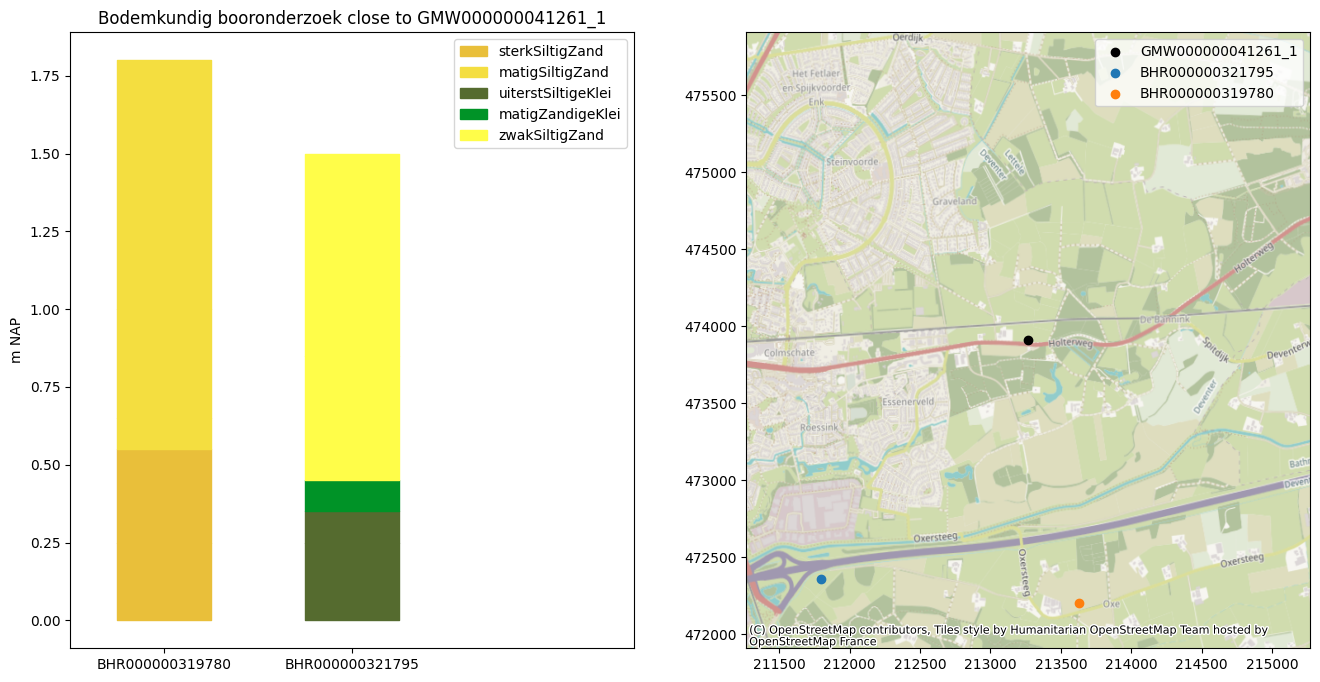

In [7]:
# specify colors for soil types
color_dic = {
    "sterkSiltigZand": [
        0.9137254901960784,
        0.7490196078431373,
        0.22745098039215686,
        1.0,
    ],
    "matigSiltigZand": [
        0.9568627450980393,
        0.8705882352941177,
        0.25098039215686274,
        1.0,
    ],
    "uiterstSiltigeKlei": [
        0.3333333333333333,
        0.4196078431372549,
        0.1843137254901961,
        1.0,
    ],
    "matigZandigeKlei": [0.0, 0.5764705882352941, 0.15294117647058825, 1.0],
    "zwakSiltigZand": [1.0, 0.9921568627450981, 0.28627450980392155, 1.0],
}

# add colors based on column 'standard_name'
col = "standard_name"
boreholes.data.df["color"] = boreholes.data.df[col].map(color_dic)

# plot borehole data
f, axes = plt.subplots(figsize=(16, 8), ncols=2)
labels = []
for i, (bro_id, df) in enumerate(boreholes.data.df.groupby("nr")):
    for _, row in df.iterrows():
        if row[col] in labels:
            axes[0].fill_between(
                [i - 0.25, i + 0.25],
                [row["top"], row["top"]],
                [row["bottom"], row["bottom"]],
                color=row["color"],
            )
        else:
            axes[0].fill_between(
                [i - 0.25, i + 0.25],
                [row["top"], row["top"]],
                [row["bottom"], row["bottom"]],
                color=row["color"],
                label=row[col],
            )
            labels.append(row[col])
axes[0].set_xticks(np.arange(0, i + 1), boreholes.data.df["nr"].unique())
if boreholes.header.vertical_reference == 5709:
    axes[0].set_ylabel("m NAP")
axes[0].set_xlim(-0.5, i + 1.5)
axes[0].legend()
axes[0].set_title(f"Bodemkundig booronderzoek close to {gw_bro.name}")
# plot map

# plot well
axes[1].scatter(gw_bro.x, gw_bro.y, label=gw_bro.name, color="black")

# plot boreholes
for i, dfnr in boreholes.data.df.groupby(["x", "y"]):
    axes[1].scatter(*i, label=dfnr["nr"].unique()[0])

# settings
axes[1].set_xlim(extent[:2])
axes[1].set_ylim(extent[2:])
axes[1].legend()

# basemap
ctx.add_basemap(axes[1], crs=28992)